# Modelling

In [1]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from scipy.ndimage.filters import gaussian_filter
import shap
import pickle
from math import cos, sin, asin, sqrt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf    
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Input, concatenate, SimpleRNN, Dropout, Bidirectional, Embedding, GRU
from keras.callbacks import History
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
history = History()

In [2]:
df = pd.read_csv("C:\\Data\\Processed_M3\\Sites_10min_time_final.csv")

In [3]:
timeInterval = '10min_time'
# df.columns = ['date', 'site', timeInterval, 'occupancy0', 'speed0', 'volume0','dateTime', 'hour', 'dayOfWeek', 'dayType']
df.columns = ['date','site','timeInterval','occupancy0','speed0','volume0','dateTime','hour','dayOfWeek','dayType','density0','state0']
sites = set(df['site'])
dateTime = pd.to_datetime(df['dateTime'])
df['interval'] = [v.hour*6+int(v.minute/10) for v in dateTime]
df

,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval
0,2016-07-01,14005 WB P0,00:00:00,0.000000,100.000000,67.728571,2016-07-01 00:00:00,0,4,0,0.000000,0.0,0
1,2016-07-01,14005 WB P0,00:10:00,0.000000,100.000000,62.821429,2016-07-01 00:10:00,0,4,0,0.000000,0.0,1
2,2016-07-01,14005 WB P0,00:20:00,0.000000,100.000000,53.171429,2016-07-01 00:20:00,0,4,0,0.000000,0.0,2
3,2016-07-01,14005 WB P0,00:30:00,0.000000,100.000000,51.971429,2016-07-01 00:30:00,0,4,0,0.000000,0.0,3
4,2016-07-01,14005 WB P0,00:40:00,0.000000,100.000000,44.350000,2016-07-01 00:40:00,0,4,0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51403,2016-08-21,14063 WB P0,23:10:00,0.890000,97.012222,62.000000,2016-08-21 23:10:00,23,6,1,1.260833,0.0,139
51404,2016-08-21,14063 WB P0,23:20:00,0.436667,96.243056,78.750000,2016-08-21 23:20:00,23,6,1,0.618611,0.0,140
51405,2016-08-21,14063 WB P0,23:30:00,0.490000,96.452778,36.000000,2016-08-21 23:30:00,23,6,1,0.694167,0.0,141
51406,2016-08-21,14063 WB P0,23:40:00,0.520000,96.370833,70.687500,2016-08-21 23:40:00,23,6,1,0.736667,0.0,142


## Features

In [38]:
# The lag is the time distance between time-factors and time-target
# If the lag is 0, we say we try to use the data 10 mins ago to forecast the now traffic condition
# If the lag is 2, we say we try to use the data 30 mins ago to forecast the now traffic condition
# If the lag is 5, we say we try to use the data 60 mins ago to forecast the now traffic condition

window = 6*10
lag = 5 # lag 0 means the label is 10 mins later
lag = lag + window

# sites = ['14005 WB P0', '14017 WB P0', '14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0', '14061 WB P0']
# # sites = ['14025 WB P0']
# sites = ['14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0']

# lag_names = ['volume'+str(t) for t in range(lag+1)]
volume_names = 'volume'+str(lag)
hour_names = 'hour'+str(lag)
dayOfWeek_names = 'dayOfWeek'+str(lag)
interval_names = 'interval'+str(lag)
dayType_names = 'dayType'+str(lag)
data_features = [volume_names, hour_names, dayOfWeek_names, interval_names, dayType_names]

column_names = list(df.columns.values) + data_features
print(column_names)

data = pd.DataFrame()
for site in sites:
    df1 = df[df['site']==site]
    df1.sort_values('dateTime')
    # df1 = pd.concat([df1]+ [df1['volume0'].shift(t) for t in range(lag+1)], axis=1)
    df1 = pd.concat([df1]+ [df1['volume0'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['hour'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayOfWeek'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['interval'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayType'].shift(lag)], axis=1)
    data = data.append(df1)
data.columns = column_names
#data = data.dropna()

features = ['volume' + str(lag)]
features_name = 'volume' + str(lag)
aux_features = []#[interval_names, dayType_names]
columns = features + aux_features
data

['date', 'site', 'timeInterval', 'occupancy0', 'speed0', 'volume0', 'dateTime', 'hour', 'dayOfWeek', 'dayType', 'density0', 'state0', 'interval', 'volume65', 'hour65', 'dayOfWeek65', 'interval65', 'dayType65']


,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval,volume65,hour65,dayOfWeek65,interval65,dayType65
864,2016-07-01,14063 WB P0,00:00:00,0.323333,92.979167,24.000,2016-07-01 00:00:00,0,4,0,0.458056,0.0,0,NaN,NaN,NaN,NaN,NaN
865,2016-07-01,14063 WB P0,00:10:00,0.560000,96.808642,33.000,2016-07-01 00:10:00,0,4,0,0.793333,0.0,1,NaN,NaN,NaN,NaN,NaN
866,2016-07-01,14063 WB P0,00:20:00,0.233333,99.395833,16.000,2016-07-01 00:20:00,0,4,0,0.330556,0.0,2,NaN,NaN,NaN,NaN,NaN
867,2016-07-01,14063 WB P0,00:30:00,0.286667,97.055556,23.000,2016-07-01 00:30:00,0,4,0,0.406111,0.0,3,NaN,NaN,NaN,NaN,NaN
868,2016-07-01,14063 WB P0,00:40:00,0.256667,97.531250,24.000,2016-07-01 00:40:00,0,4,0,0.363611,0.0,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50827,2016-08-21,14025 WB P0,23:10:00,1.115000,97.785278,196.000,2016-08-21 23:10:00,23,6,1,1.579583,0.0,139,1758.0,12.0,6.0,74.0,1.0
50828,2016-08-21,14025 WB P0,23:20:00,1.215000,96.938611,200.000,2016-08-21 23:20:00,23,6,1,1.721250,0.0,140,1476.0,12.0,6.0,75.0,1.0
50829,2016-08-21,14025 WB P0,23:30:00,0.777500,96.207778,309.750,2016-08-21 23:30:00,23,6,1,1.101458,0.0,141,1544.0,12.0,6.0,76.0,1.0
50830,2016-08-21,14025 WB P0,23:40:00,0.706250,99.625694,277.125,2016-08-21 23:40:00,23,6,1,1.000521,0.0,142,1408.0,12.0,6.0,77.0,1.0


## Evaluation

In [39]:
def evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Function for calculating accuracy metrics. Inputs are list of predictions.
    """
    results = {}
    
    results['MAE train'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['MAE test'] = mean_absolute_error(y_pred_test, y_test_true)
    results['MAE train base'] = mean_absolute_error(y_base_train, y_train_true)
    results['MAE test base'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['MRE test'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['RMSE test'] = math.sqrt(mean_squared_error(y_pred_test, y_test_true))
    
    #print('results', results)
    #print('y_base_train', y_base_train) # y_base_train, y_base_test are not dataframe anymore
    
    total_error_train, total_error_test = 0,0
    total_error_train_base, total_error_test_base = 0,0
    
    for i in range(0, len(y_train_true)):
        total_error_train_base += np.abs(y_base_train[i] - y_train_true[i])
        total_error_train += np.abs(y_pred_train[i] - y_train_true[i])
    
    for i in range(0, len(y_test_true)):
        total_error_test_base += np.abs(y_base_test[i] - y_test_true[i])
        total_error_test += np.abs(y_pred_test[i] - y_test_true[i])
        
    results['Baseline model total error (on train set)'] = total_error_train_base
    results['Baseline model total error (on test set)'] = total_error_test_base
    results['Our model total error (on train set)'] = total_error_train
    results['Our model total error (on test set)'] = total_error_test 
    
    return results

In [40]:
def evaluate_model_ann(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Calculate mean squared error and total absolute error.
    evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)
    """
    results = {}
    
    results['train mae'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['test mae'] = mean_absolute_error(y_pred_test, y_test_true)
    results['base train mae'] = mean_absolute_error(y_base_train, y_train_true)
    results['base test mae'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['test mre'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['test rmse'] = mean_squared_error(y_pred_test, y_test_true)**.5
    
    error_train, error_test = [],[]
    error_train_base, error_test_base = [],[]
    
    for i in range(0, len(y_train_true)):
        error_train_base.append(np.abs(y_base_train[i] - y_train_true[i]))
        error_train.append(np.abs(y_pred_train[i] - y_train_true[i]))
    
    for i in range(0, len(y_test_true)):
        error_test_base.append(np.abs(y_base_test[i] - y_test_true[i]))
        error_test.append(np.abs(y_pred_test[i] - y_test_true[i]))
        
    results['base model train error'] = sum(error_train_base)
    results['base model test error'] = sum(error_test_base)
    results['our model train error'] = sum(error_train)
    results['our model test error'] = sum(error_test) 
    
    return results

In [41]:
def scatter_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)
    y_predicted = y_pred_test
    t = y_true
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_predicted, c=t, s=2, cmap='viridis')
    ax.plot([0,2000], [0,2000], 'k--', lw=4)
    ax.set_xlabel('True', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0,2001,500))
    ax.yaxis.set_ticks(np.arange(0,2001,500))
    ax.tick_params(axis='both', labelsize=15, direction='inout',bottom=True, left=True)
    #regression line
    y_true, y_predicted = y_true.reshape(-1,1), y_predicted.reshape(-1,1)
    ax.annotate("R2 = {:.3f}".format(r2_score(y_true, y_predicted)), (0, 1400), fontsize=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def time_series_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)*6
    y_predicted = y_pred_test*6
    t = y_true
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plt.plot(y_predicted, 'r', lw=.5)
    plt.plot(y_true, 'b', lw=.5)
    ax.set_ylabel('Flow', fontsize=12)

    ax.tick_params(axis='both', labelsize=12, direction='inout',bottom=True, left=True)
    ax.set_xticklabels([])
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def show_time_scatter_plot(y_test,y_pred_test,title = "BiLSTM\\"):
    
    filePath = os.getcwd() + '\\Figs\\Scatter\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):                                     
        os.makedirs(filePath)
    scatter_plot(y_test,y_pred_test,imagePath)
    
    filePath = os.getcwd() + '\\Figs\\TimeSeries\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):
        os.makedirs(filePath)
    time_series_plot(y_test,y_pred_test,imagePath)

In [42]:
def feature_importance(x_train):
    crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    plt.figure(figsize = (6, 8))
    dt_importance_df = pd.DataFrame({"attributes": x_train.columns, "importance": dt.feature_importances_})
    dt_importance_df = dt_importance_df.sort_values("importance", ascending = True)
    dt_importance_df = dt_importance_df[dt_importance_df["importance"] > 0.001]
    plt.barh(dt_importance_df["attributes"], dt_importance_df["importance"], orientation = "horizontal", color = crayon)
    plt.xlabel("Feature Importance")

## Helper Functions for Normalising Data

In [43]:
def denormalise(predictions, scaler): #IMPORTANT: run this
    """
    Denormalise the predictions back to the previous scale. 
    """
    predictions = predictions.reshape(1,-1)
    pred = scaler.inverse_transform(predictions)
    
    return pred

In [44]:
def normalise(columns, df): #IMPORTANT: run this
    """
    Normalise variables given the list 'columns'. Used for SVR model. 
    
    Parameters:
    columns (list): list of strings containing feature names that need to be normalised.
    df (pandas dataframe): training data.
    
    """
    min_max_scaler = preprocessing.MinMaxScaler() #normalise to make variables comparable 
    final_df = pd.DataFrame(min_max_scaler.fit_transform(df[columns]), columns = columns)
    
    for col in df.columns: #add back the columns that weren't normalised
        if col not in columns: 
            final_df[col] = df[col].values
    
#     if 'volume' in columns: #also store the unnormalised travel times if necessary 
#         final_df['volume_unnorm'] = df['volume'].values
    return final_df, min_max_scaler

In [45]:
def create_auxiliary_input(train_x, test_x, features): 
    """
    Function to filter out only the auxiliary features. 
    Auxiliary features are all the other features other than the lagged features.
    
    """
    
    train_x_aux = train_x[features]
    test_x_aux = test_x[features]
    
    return train_x_aux, test_x_aux

## Helper Functions for Window the data

when we try to use 1 previous hour to preduct 1 further hour, the input window is 2.

Input window = history length (1) + lag (1)

In [46]:
def time_series_window_generator(x,y,lag,window,features_name):
    """
    1. we assume the train test is dataframe format, 
    and it contains both time series and other features
       
    2. we consider the base line is the first data points of input (only work for methods don't need normalization)
    
    3. for methods use normalization, we need to generate the baseline inside the method itself
    """
    # to create the correct window match
    # --------------------------------------
    #  1  2  3  4  5   6  ......
    # --------------  --
    #   features      label
    # 
    # this is a window 6, lag 1, data length 5 data match for time series.
    # didn't use this function for now because vol-x are manually generated

    local_x = x.copy()
    local_x_base = x[features_name].copy()
    local_y = y.copy()
    #print(y)
    
    index_x = local_x.index
    index_y = local_y.index
    data_n = len(x) - lag               # for 5 window 0 lag, means 5 data points predict 1 future hour.

    y_base_windowed = []
    y_windowed = []
    x_windowed = []
    
    for i in range(data_n):
        x_windowed.append(local_x[i : i+window].values.tolist())  # get features
        y_windowed.append(local_y[index_y[i]])
        y_base_windowed.append(local_x_base[index_x[i]])
#         if i == 0:
#             print('start_index ',index_x[0])
#             print("* processing the time series " + str(window) +" window in lag " + str(lag-window))
#             print('features: ', local_x[i : i+window], ' in ', str(index_x[0]),  ' to ', str(index_x[0]+window))
#             print('label: ', local_y[index_y[i]], ' in ', str(index_y[0]))

    # reshape to (n_sample, n_feautre * n_length) still 2d
    x_windowed = np.array(x_windowed)
    # print('input shape before:', x_windowed.shape)
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0],-1))
    # print('input shape after:', x_windowed.shape)
    
    return x_windowed, y_windowed, y_base_windowed

In [47]:
def prepare_nn_data(x,y,lag,window,time_feautre_name = 'volume1'):
    """
    Reformat data to appropriate form for the recurrent neural
    network.
    1. get time series data in array (n_sample,1,n_length)
    2. get aux data in array (n_sample,1,n_features)
    3. get y & y_base in array (n_sample,)
    
    to separate 1 and 2, use time_feautre_name
    """
    # separate 1 and 2
    print("==================")
    print("process ann data")
    local_x = x.copy()
    index_y = y.index
    time_feature_df = local_x[time_feautre_name]
    aux_feature_df = local_x.drop(time_feautre_name, axis=1)

    x_windowed = []
    x_windowed_aux = []
    y_base_windowed = []
    y_windowed = []
    
    data_n = len(x) - lag
    for i in range(data_n):
        x_windowed.append(time_feature_df[i : i+window].values.tolist())     # get time series features
        x_windowed_aux.append(aux_feature_df[i : i+window].values.tolist())  # get other time related features
        y_base_windowed.append(time_feature_df[i])                    # get first of input time slot data as baseline 
        y_windowed.append((y[index_y[i]]))                                   # get grand truth
        
    # reshape to (n_sample, 1 feautre)
    x_windowed = np.asarray(x_windowed).astype(np.float32)
    x_windowed_aux = np.asarray(x_windowed_aux).astype(np.float32)
    y_base_windowed = np.asarray(y_base_windowed).astype(np.float32)
    y_windowed = np.asarray(y_windowed).astype(np.float32)
    #print('before reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('sample input time series:',x_windowed[0])
    #print('sample input aux features::',x_windowed_aux[0])
    #print('target shape:',y_windowed.shape)
    #print('sample target:',y_windowed[0])
    
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0], 1, x_windowed.shape[1]))
    x_windowed_aux = np.reshape(x_windowed_aux, (x_windowed_aux.shape[0],1, -1))      # for merge must be n,1,m.
    y_base_windowed = np.reshape(y_base_windowed, (y_base_windowed.shape[0], 1))
    y_windowed = np.reshape(y_windowed, (y_windowed.shape[0], 1))
    #print('after reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('target shape:',y_windowed.shape)
    
    return x_windowed, x_windowed_aux, y_windowed, y_base_windowed

# Models

# Neural network models

The following sections use different neural networks, which are MLP, RNN, LSTM, GRU and BILSTM. However their general structure are same.

See below


In [48]:
# ################
# this model architecture actually is a 2 branch model
#  input1 time series               
#     |
#  RNN model        
#     |                       
#  RNN output     input2 other features
#     |                     |
#     -----------------------
#                |
#              Concat
#                |
#               MLP
#                |
#           final output


# RNN

14063 WB P0
process ann data
process ann data
train mae 26.952005
test mae 27.231783
base train mae 353.84875
base test mae 349.15536
test mre 0.19776426
test rmse 41.469175358123685
base model train error [2014816.4]
base model test error [508370.3]
our model train error [153464.66]
our model test error [39649.43]
Model R square (train):  0.9669600416940911
Model R square (test):  0.9616556257167658
Base R square (train):  -1.9868835673341532
Base R square (test):  -2.0592748048182385


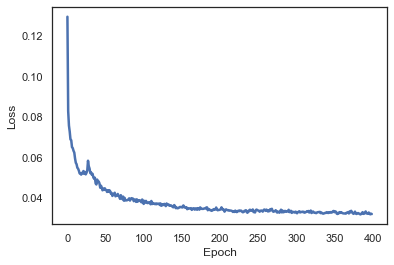

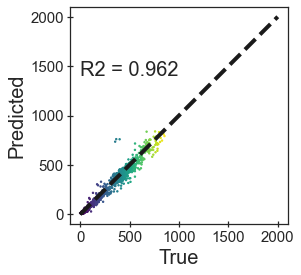

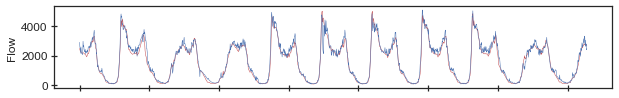

14005 WB P0
process ann data
process ann data
train mae 39.73934
test mae 39.636578
base train mae 453.74377
base test mae 475.86014
test mre 0.14014661
test rmse 56.10826544433427
base model train error [2583616.2]
base model test error [692852.2]
our model train error [226275.75]
our model test error [57710.844]
Model R square (train):  0.9600376610268797
Model R square (test):  0.9629783259112283
Base R square (train):  -1.9782323006722655
Base R square (test):  -2.086775442359122


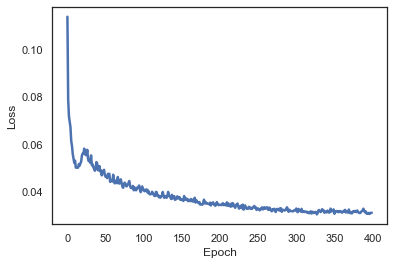

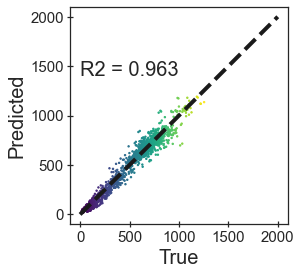

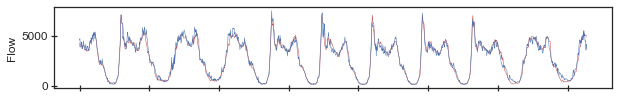

14049 WB P0
process ann data
process ann data
train mae 38.6225
test mae 40.152386
base train mae 614.98596
base test mae 621.85913
test mre 0.1358872
test rmse 59.597701183251395
base model train error [3501731.8]
base model test error [905427.]
our model train error [219916.61]
our model test error [58461.836]
Model R square (train):  0.9763713223121117
Model R square (test):  0.9741168950045694
Base R square (train):  -2.1163853679178994
Base R square (test):  -2.173189180862907


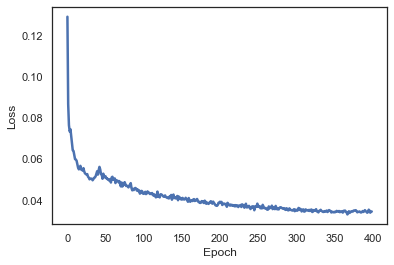

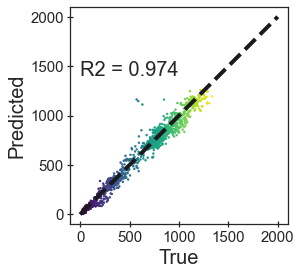

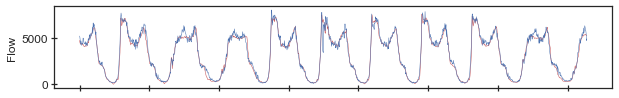

14055 WB P0
process ann data
process ann data
train mae 82.94211
test mae 92.77951
base train mae 1161.4429
base test mae 1154.9071
test mre 1.0240015
test rmse 141.14604858532172
base model train error [6613257.]
base model test error [1681544.9]
our model train error [472272.9]
our model test error [135087.]
Model R square (train):  0.9717710056943211
Model R square (test):  0.9583295252296591
Base R square (train):  -2.090005226154333
Base R square (test):  -2.1506376708754043


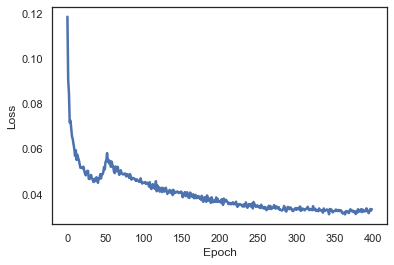

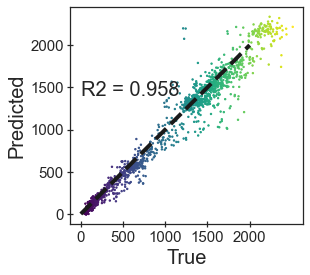

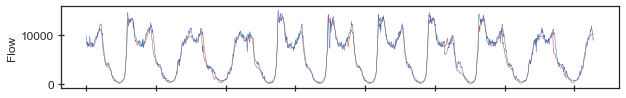

14037 WB P0
process ann data
process ann data
train mae 74.47306
test mae 73.79471
base train mae 1015.1305
base test mae 1013.4442
test mre 0.16269688
test rmse 106.15208723807554
base model train error [5780153.5]
base model test error [1475575.1]
our model train error [424049.47]
our model test error [107445.1]
Model R square (train):  0.9699530850541189
Model R square (test):  0.9695994993245073
Base R square (train):  -2.0921402724220592
Base R square (test):  -2.134143630460895


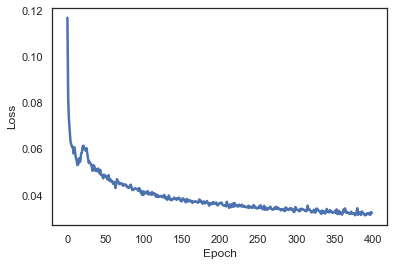

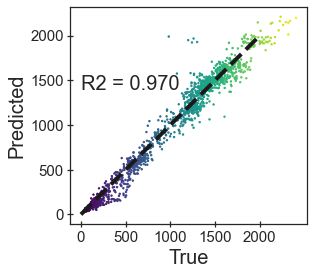

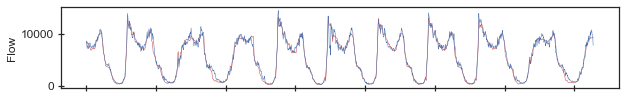

14011 WB P0
process ann data
process ann data
train mae 68.97556
test mae 75.16303
base train mae 825.08026
base test mae 828.1028
test mre 0.18923496
test rmse 102.69754211396688
base model train error [4698007.]
base model test error [1205717.6]
our model train error [392747.2]
our model test error [109437.38]
Model R square (train):  0.9658615885530046
Model R square (test):  0.9597930708748416
Base R square (train):  -1.8940366304422827
Base R square (test):  -1.947690725584537


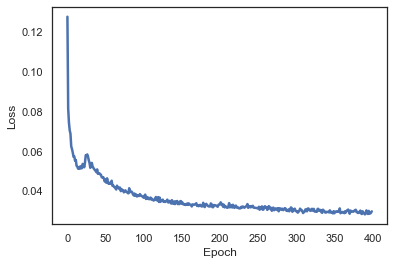

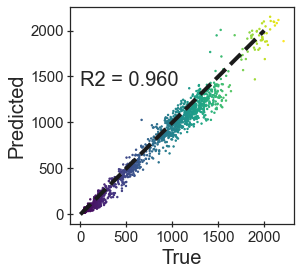

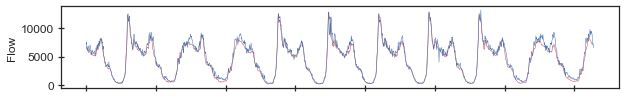

14025 WB P0
process ann data
process ann data
train mae 66.87272
test mae 69.857895
base train mae 991.03076
base test mae 992.7998
test mre 0.15633644
test rmse 100.46458486700674
base model train error [5642928.]
base model test error [1445516.5]
our model train error [380772.62]
our model test error [101713.11]
Model R square (train):  0.9764130535965776
Model R square (test):  0.9725008513486157
Base R square (train):  -1.942159354838985
Base R square (test):  -2.0003753681308414


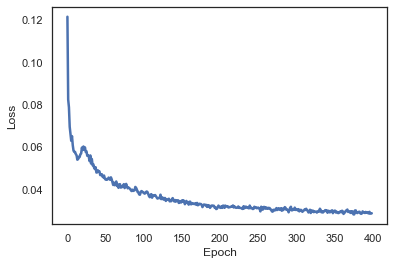

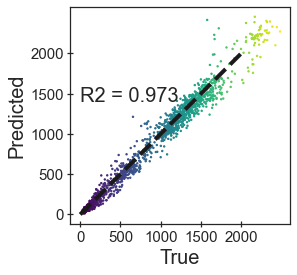

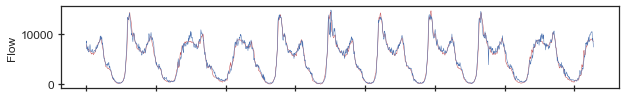

sums of MAE test /counter 59.80227034432547


In [53]:
final = pd.DataFrame()
MAE_RNN, MRE_RNN, RMSE_RNN = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    rnn_out = SimpleRNN(64,return_sequences=True, activation = 'linear',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([rnn_out, aux_input]) #concatenate auxiliary features with rnn output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) #plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_RNN[siteId] = res['test mae']
    MRE_RNN[siteId] = res['test mre']
    RMSE_RNN[siteId] = res['test rmse']

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "RNN\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rnn.csv',index=False)

sums, counter = 0, 0
for key in MAE_RNN:
    sums += MAE_RNN[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

# return MAE_RNN
    

# LSTM

14063 WB P0
process ann data
process ann data
MAE 23.551481
MRE 0.15732153
RMSE 37.04611878445821


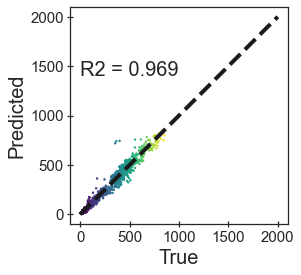

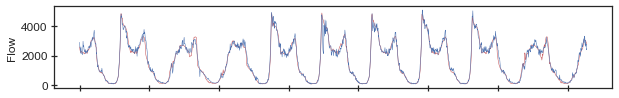

14005 WB P0
process ann data
process ann data
MAE 45.33719
MRE 0.216913
RMSE 63.47113678734709


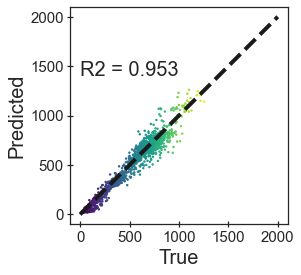

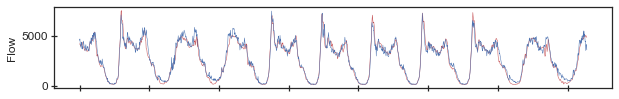

14049 WB P0
process ann data
process ann data
MAE 40.545803
MRE 0.11787821
RMSE 61.39103858985141


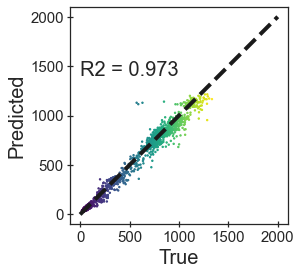

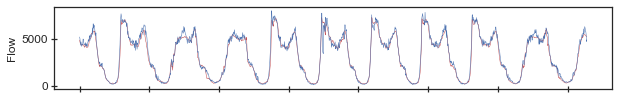

14055 WB P0
process ann data
process ann data
MAE 97.99514
MRE 0.1988303
RMSE 151.47763732437537


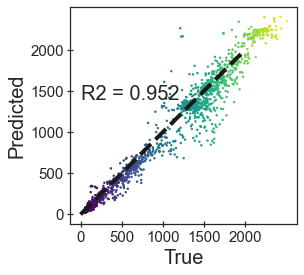

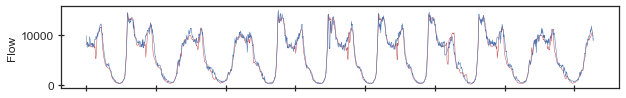

14037 WB P0
process ann data
process ann data
MAE 77.89326
MRE 0.15079018
RMSE 118.3845074389487


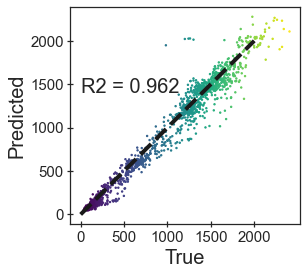

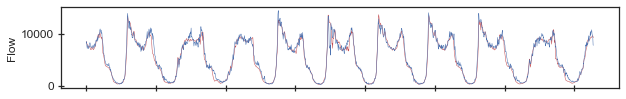

14011 WB P0
process ann data
process ann data
MAE 68.617874
MRE 0.1565089
RMSE 97.55639895241367


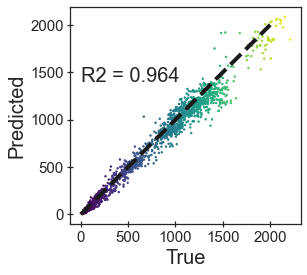

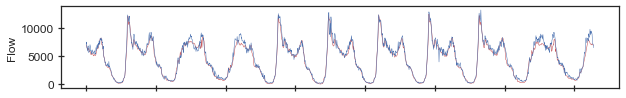

14025 WB P0
process ann data
process ann data
MAE 64.8445
MRE 0.12050003
RMSE 95.05787710652916


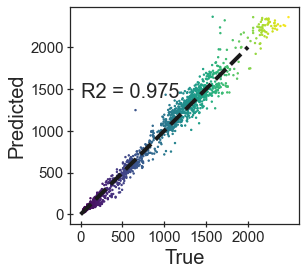

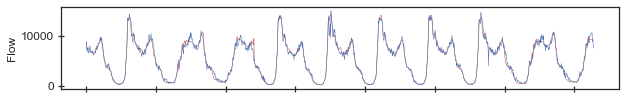

sums of MAE test /counter 59.826463154384065


In [50]:
final = pd.DataFrame()
MAE_LSTM, MRE_LSTM, RMSE_LSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_LSTM[siteId] = res['test mae']
    MRE_LSTM[siteId] = res['test mre']
    RMSE_LSTM[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "LSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_lstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_LSTM:
    sums += MAE_LSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# GRU

14063 WB P0
process ann data
process ann data
MAE 23.905722
MRE 0.18354696
RMSE 36.84736285562459


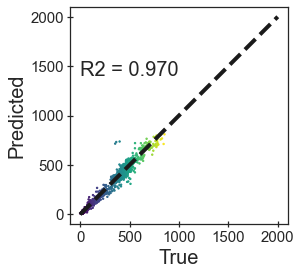

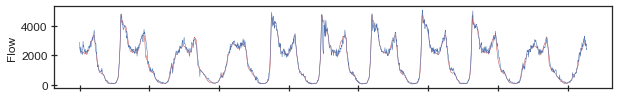

14005 WB P0
process ann data
process ann data
MAE 41.361233
MRE 0.1880069
RMSE 57.24617038228409


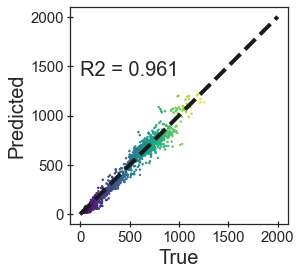

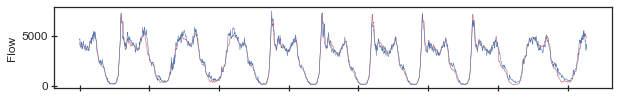

14049 WB P0
process ann data
process ann data
MAE 38.119553
MRE 0.11716253
RMSE 58.013432492909565


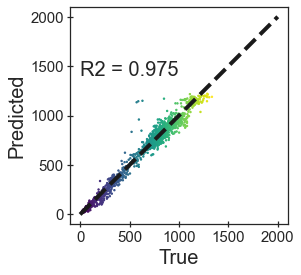

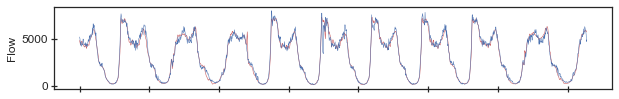

14055 WB P0
process ann data
process ann data
MAE 80.93371
MRE 0.13178977
RMSE 123.40153748282474


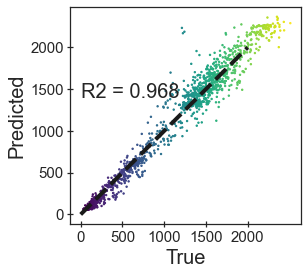

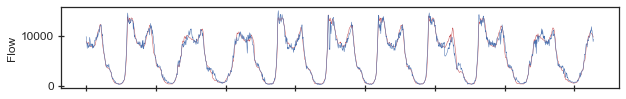

14037 WB P0
process ann data
process ann data
MAE 71.481766
MRE 0.15993625
RMSE 106.39566760887165


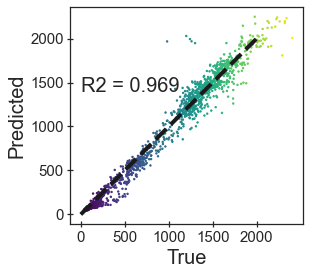

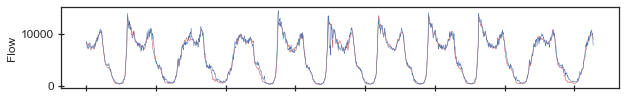

14011 WB P0
process ann data
process ann data
MAE 62.332767
MRE 0.11973597
RMSE 88.0196816369427


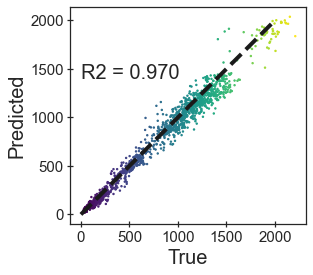

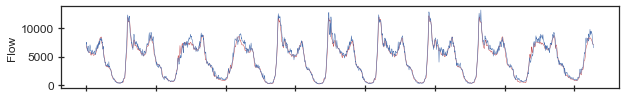

14025 WB P0
process ann data
process ann data
MAE 68.552414
MRE 0.14599542
RMSE 96.64656029671983


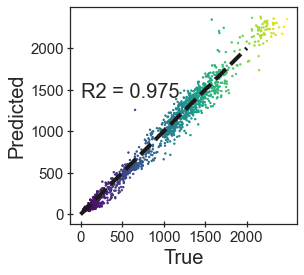

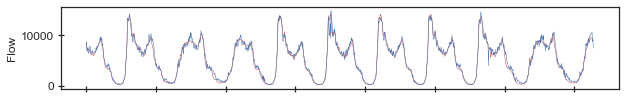

sums of MAE test /counter 55.241023199898855


In [51]:
final = pd.DataFrame()
MAE_GRU, MRE_GRU, RMSE_GRU = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    gru_out = GRU(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([gru_out, aux_input]) #concatenate auxiliary features with gru output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_GRU[siteId] = res['test mae']
    MRE_GRU[siteId] = res['test mre']
    RMSE_GRU[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "GRU\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_gru.csv',index=False)

sums, counter = 0, 0
for key in MAE_GRU:
    sums += MAE_GRU[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# Bidirectional LSTM

14063 WB P0
process ann data
process ann data
train mae 24.690815
test mae 24.8974
base train mae 353.84875
base test mae 349.15536
test mre 0.18770105
test rmse 38.101669026660595
base model train error [2014816.4]
base model test error [508370.3]
our model train error [140589.38]
our model test error [36250.617]
Model R square (train):  0.9713250309915382
Model R square (test):  0.967630289202868
Base R square (train):  -1.9868835673341532
Base R square (test):  -2.0592748048182385


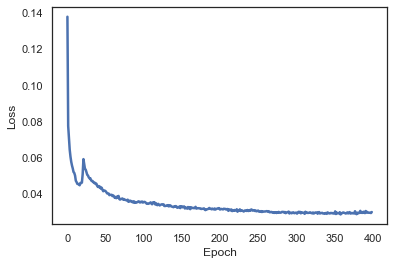

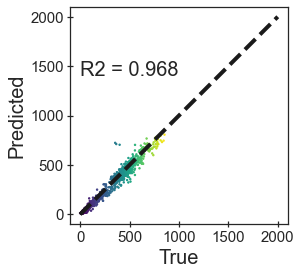

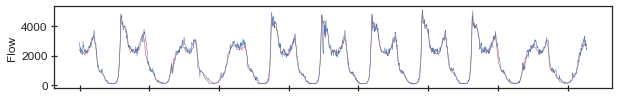

14005 WB P0
process ann data
process ann data
train mae 45.35358
test mae 47.198742
base train mae 453.74377
base test mae 475.86014
test mre 0.26427186
test rmse 63.45751108332744
base model train error [2583616.2]
base model test error [692852.2]
our model train error [258243.03]
our model test error [68721.37]
Model R square (train):  0.9546213205999912
Model R square (test):  0.9526447175518262
Base R square (train):  -1.9782323006722655
Base R square (test):  -2.086775442359122


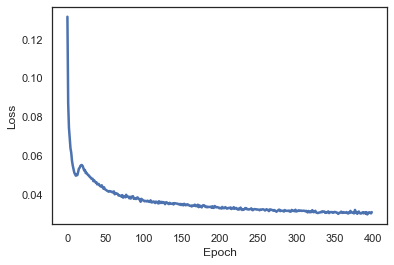

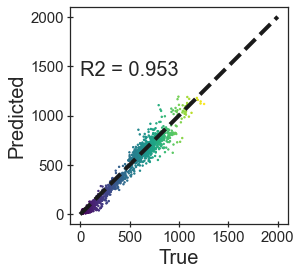

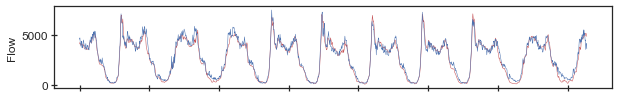

14049 WB P0
process ann data
process ann data
train mae 41.1349
test mae 41.891743
base train mae 614.98596
base test mae 621.85913
test mre 0.11739538
test rmse 62.18549973227782
base model train error [3501731.8]
base model test error [905427.]
our model train error [234222.12]
our model test error [60994.44]
Model R square (train):  0.9741570193690013
Model R square (test):  0.9718203465508962
Base R square (train):  -2.1163853679178994
Base R square (test):  -2.173189180862907


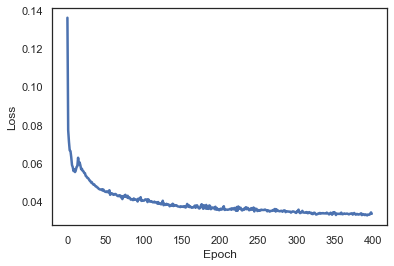

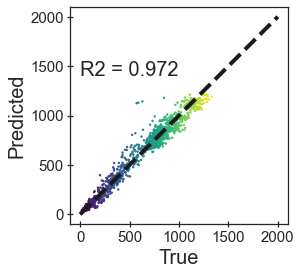

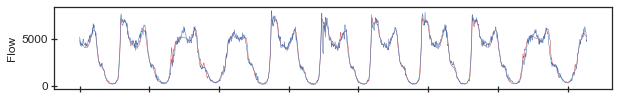

14055 WB P0
process ann data
process ann data
train mae 71.045395
test mae 75.9053
base train mae 1161.4429
base test mae 1154.9071
test mre 0.13073227
test rmse 118.80026485529189
base model train error [6613257.]
base model test error [1681544.9]
our model train error [404531.72]
our model test error [110518.125]
Model R square (train):  0.9781237033690254
Model R square (test):  0.9704793597351631
Base R square (train):  -2.090005226154333
Base R square (test):  -2.1506376708754043


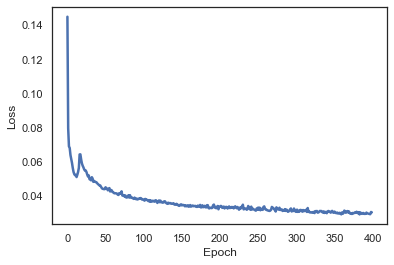

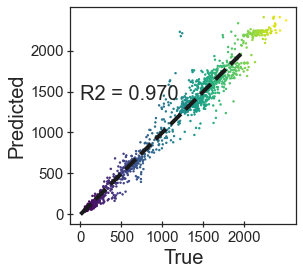

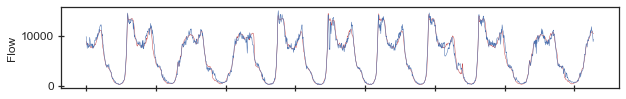

14037 WB P0
process ann data
process ann data
train mae 69.91848
test mae 73.67485
base train mae 1015.1305
base test mae 1013.4442
test mre 0.15890767
test rmse 109.75850177064873
base model train error [5780153.5]
base model test error [1475575.1]
our model train error [398115.5]
our model test error [107270.57]
Model R square (train):  0.9728728753707523
Model R square (test):  0.9674987568360476
Base R square (train):  -2.0921402724220592
Base R square (test):  -2.134143630460895


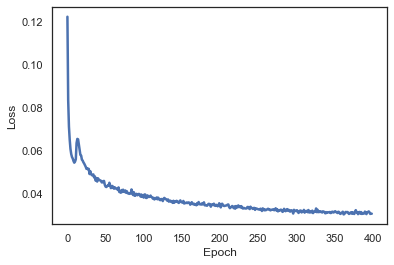

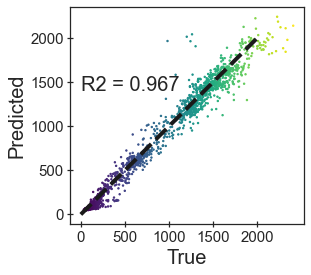

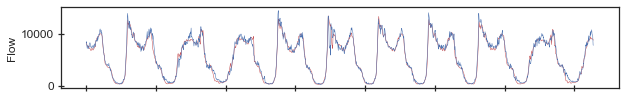

14011 WB P0
process ann data
process ann data
train mae 64.064644
test mae 70.39733
base train mae 825.08026
base test mae 828.1028
test mre 0.14005132
test rmse 106.3340981514749
base model train error [4698007.]
base model test error [1205717.6]
our model train error [364784.2]
our model test error [102498.5]
Model R square (train):  0.9647544454723852
Model R square (test):  0.9568951723497033
Base R square (train):  -1.8940366304422827
Base R square (test):  -1.947690725584537


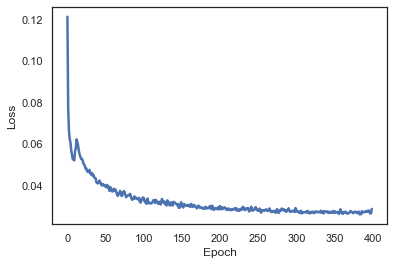

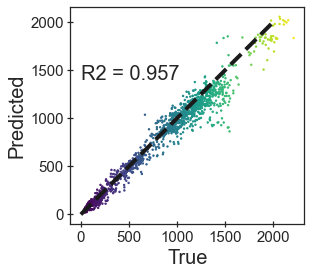

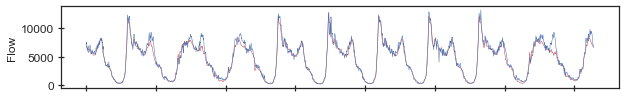

14025 WB P0
process ann data
process ann data
train mae 61.160015
test mae 63.76675
base train mae 991.03076
base test mae 992.7998
test mre 0.13882247
test rmse 91.3874553327069
base model train error [5642928.]
base model test error [1445516.5]
our model train error [348244.5]
our model test error [92844.336]
Model R square (train):  0.9798374863884963
Model R square (test):  0.9772455442363333
Base R square (train):  -1.942159354838985
Base R square (test):  -2.0003753681308414


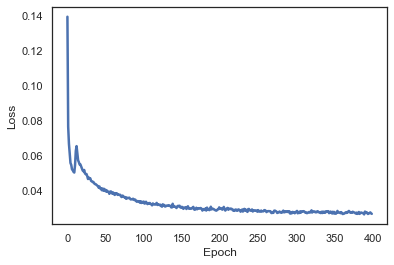

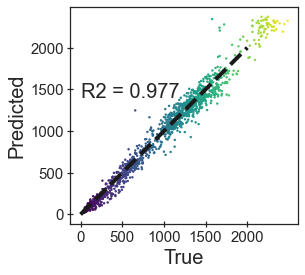

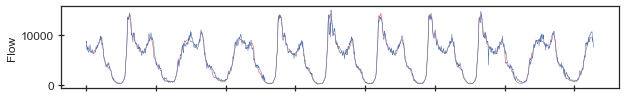

sums of MAE test /counter 56.818873269217356


In [52]:
final = pd.DataFrame()
MAE_BiLSTM, MRE_BiLSTM, RMSE_BiLSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = Bidirectional(LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001))) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])      


    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                   {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)


    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_BiLSTM[siteId] = res['test mae']
    MRE_BiLSTM[siteId] = res['test mre']
    RMSE_BiLSTM[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "BiLSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_bilstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_BiLSTM:
    sums += MAE_BiLSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)


# Regression Tree

14063 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 31.928480436777004
MRE 0.16187208508910156
RMSE 56.410110769611336


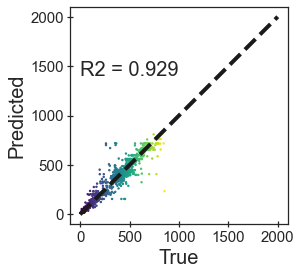

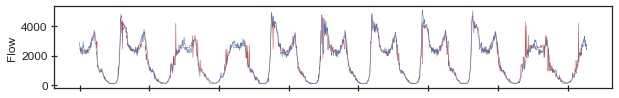

14005 WB P0
Best paramaters:  {'min_samples_leaf': 20, 'max_features': 5, 'max_depth': 10} 

MAE 59.11323572689515
MRE 0.17222751300414638
RMSE 89.94369466411919


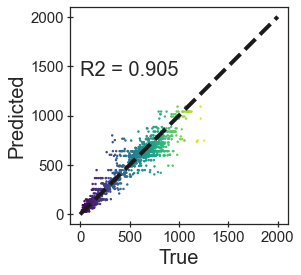

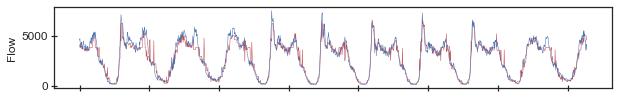

14049 WB P0
Best paramaters:  {'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 8} 

MAE 52.590493879779224
MRE 0.1444376960981466
RMSE 87.55262816667579


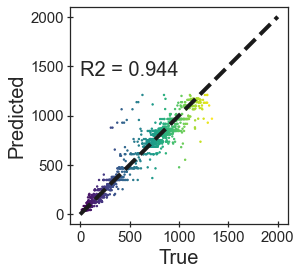

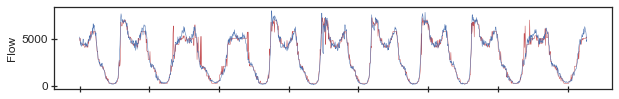

14055 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 97.66645155028667
MRE 0.13561055763075233
RMSE 168.13847852180461


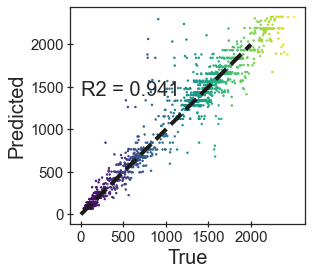

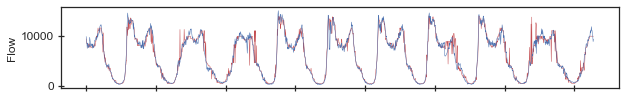

14037 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 87.47331304237495
MRE 0.128164293108589
RMSE 146.3299104441331


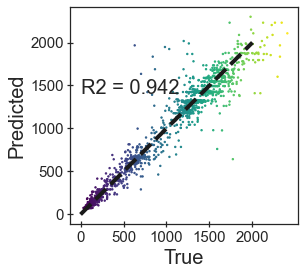

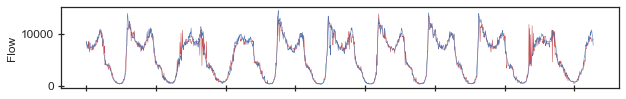

14011 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 76.01852432881604
MRE 0.13997021447160438
RMSE 117.46286726347738


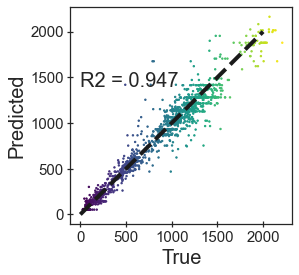

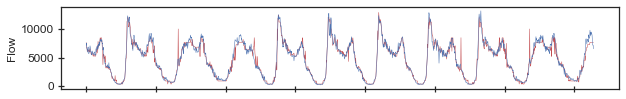

14025 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 85.36336505427067
MRE 0.15976525660878507
RMSE 142.83839159842438


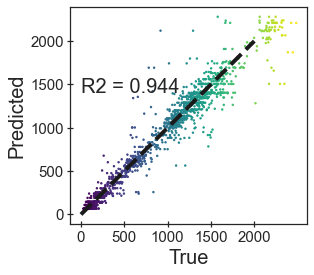

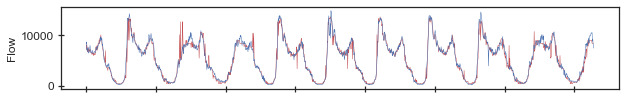

sums of MAE test /counter 70.0219805741714


In [60]:
final = pd.DataFrame()
MAE_RT, MRE_RT, RMSE_RT = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    dt_model = DecisionTreeRegressor() 
    tuning_parameters = {
        #the number of features to consider when looking for best split.
        'max_features': [1,2,3,4,5,6],
        #minimum number of samples required to be at the leaf node.
        'min_samples_leaf': [1, 5, 10, 20],
        'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    }
    dt_search = RandomizedSearchCV(dt_model, tuning_parameters, cv = 10, n_iter = 20,
                                  return_train_score = False, n_jobs = 4, 
                                  random_state = 20)

    #fitting the random forest model. Takes around 2 minutes to run.  
    dt_search.fit(x_train_win, y_train_win) 
    dt = dt_search.best_estimator_ 
    print("Best paramaters: ", dt_search.best_params_, '\n')

    ### Save regression tree model.
    pkl_folder = os.getcwd() + "\\Models\\RT\\" 
    pkl_filename = pkl_folder + "RT_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    if not os.path.exists(pkl_folder):                                       # create folder to store BFS results
        os.makedirs(pkl_folder)

    with open(pkl_filename, 'wb') as file:
        pickle.dump(dt_search, file)
    
#     pkl_folder = os.getcwd() + "\\Models\\RT\\" 
#     pkl_filename = pkl_folder + "RT_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
#     dt_search= pickle.load(open(pkl_filename,'rb'))

    
    # forecasting results
    y_pred_train = dt_search.predict(x_train_win)
    y_pred_test = dt_search.predict(x_test_win)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_RT[siteId] = res['MAE test']
    MRE_RT[siteId] = res['MRE test']
    RMSE_RT[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    show_time_scatter_plot(y_test_win,y_pred_test, title = "RT\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rt.csv',index=False)

sums, counter = 0, 0
for key in MAE_RT:
    sums += MAE_RT[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

#return MAE_RT

# SVM

14063 WB P0


One or more of the test scores are non-finite: [0.92250308        nan        nan 0.90840102 0.93031558 0.91975296
 0.92567019 0.92592307 0.92914853 0.92735504 0.9244561  0.89907656
 0.91870942 0.92768212 0.92507408 0.92262219 0.91288203 0.92330137
 0.91642057        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 1, 'C': 1} 

MAE 41.29543537496658
MRE 0.36673457296741113
RMSE 53.67891041493015


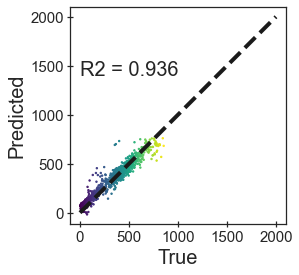

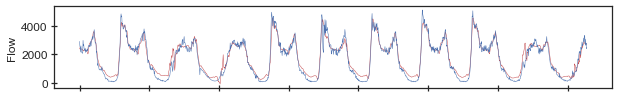

14005 WB P0


One or more of the test scores are non-finite: [0.92774052        nan        nan 0.92153287 0.92764918 0.92927334
 0.92922678 0.93294946 0.92763761 0.92983099 0.9337804  0.91259962
 0.92795751 0.92746562 0.92658236 0.93156788 0.92446589 0.93263251
 0.92413529        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.4, 'C': 0.8} 

MAE 57.66771773749337
MRE 0.454767343692877
RMSE 72.17442444984121


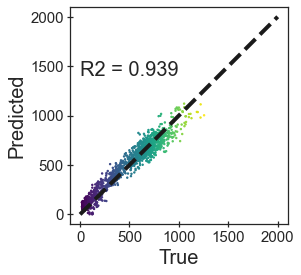

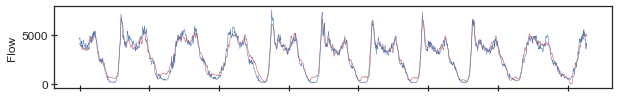

14049 WB P0


One or more of the test scores are non-finite: [0.94418975        nan        nan 0.93635882 0.94594462 0.94329211
 0.94514727 0.94654623 0.94571711 0.94554352 0.94524739 0.92921751
 0.94268299 0.94526867 0.94445098 0.94484149 0.93730651 0.9435654
 0.94045066        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.6, 'C': 1} 

MAE 72.3856863642555
MRE 0.42843975749780394
RMSE 91.72280671036314


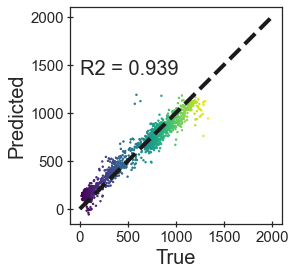

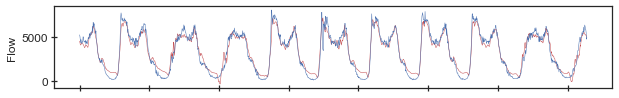

14055 WB P0


One or more of the test scores are non-finite: [0.94598748        nan        nan 0.93960126 0.94884988 0.94490153
 0.94734267 0.94849853 0.94831211 0.94808838 0.94708464 0.93214698
 0.94600908 0.94766014 0.94654843 0.94661321 0.93792935 0.94467642
 0.94272524        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 1, 'C': 1} 

MAE 140.36415426661713
MRE 0.25668375977137214
RMSE 178.61352117602598


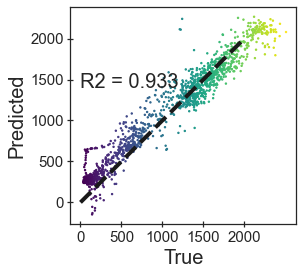

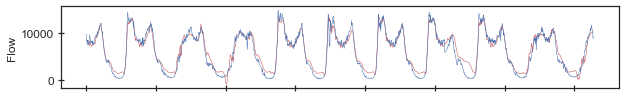

14037 WB P0


One or more of the test scores are non-finite: [0.93751569        nan        nan 0.92892917 0.93955377 0.93667105
 0.93888075 0.94066428 0.93905586 0.93954829 0.93942682 0.92023475
 0.93792018 0.9386152  0.93772716 0.93882117 0.92982239 0.93702564
 0.93364941        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.6, 'C': 1} 

MAE 114.12709644292511
MRE 0.40787067141913785
RMSE 147.64768872301926


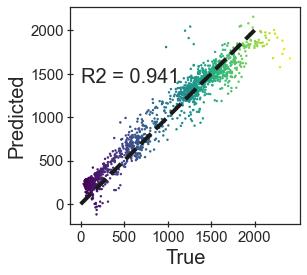

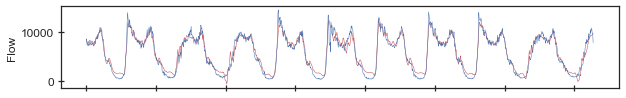

14011 WB P0


One or more of the test scores are non-finite: [0.93946224        nan        nan 0.92709777 0.93952931 0.94217946
 0.94065368 0.94494911 0.93908672 0.94120685 0.94189107 0.91753855
 0.93495101 0.93851247 0.93752443 0.94414302 0.9341603  0.94095999
 0.93532723        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.6, 'C': 1} 

MAE 92.00185601301584
MRE 0.272652837841773
RMSE 115.5830462971836


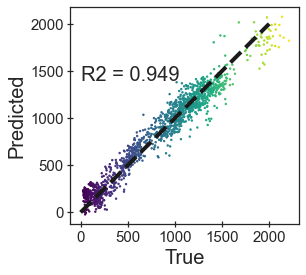

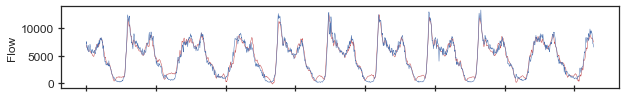

14025 WB P0


One or more of the test scores are non-finite: [0.94308903        nan        nan 0.93799314 0.94624034 0.94417457
 0.94441709 0.9478243  0.94544848 0.94545976 0.95065329 0.92720842
 0.94391722 0.94450176 0.94348619 0.94547932 0.94276326 0.94954059
 0.93971726        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.4, 'C': 0.8} 

MAE 106.61892671843756
MRE 0.38839737155916243
RMSE 138.8430639228654


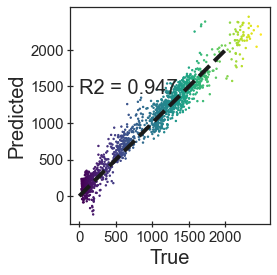

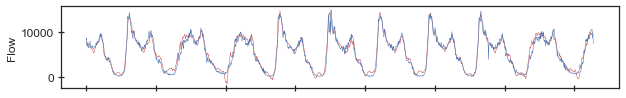

sums of MAE test /counter 89.2086961311016


In [64]:
final = pd.DataFrame()
MAE_SVR, MRE_SVR, RMSE_SVR = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)
    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    ### make sure you feed normalised data only. 
    svr_model = SVR()
    tuning_parameters = {
        'kernel': ['rbf'],
        'gamma': [0.2, 0.4, 0.6, 0.8, 1],
        'C': [0, 0.2, 0.4, 0.6, 0.8, 1]

    }
    svr_search = RandomizedSearchCV(svr_model, tuning_parameters, cv = 10, n_iter = 20,
                                  return_train_score = False, n_jobs = 4, 
                                  random_state = 20)

    svr_search.fit(x_train_win, y_train_win)
    svr = svr_search.best_estimator_ 
    print("Best paramaters: ", svr_search.best_params_, '\n')

    ### Save the models.
    pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
    pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    if not os.path.exists(pkl_folder):                                       # create folder to store BFS results
        os.makedirs(pkl_folder)

    pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
    pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(svr, file)

#     pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
#     pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
#     svr_search = pickle.load(open(pkl_filename,'rb'))

    # forecasting results
    y_pred_train_origin = svr_search.predict(x_train_win)
    y_pred_test_origin = svr_search.predict(x_test_win)

    # de-normalize the results
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    # all results:
    # y_train_win : normalized   y_pred_train_origin : normalized   --- they need be compared at same level
    # y_test_win : not nrom   y_pred_test : not norm                --- they need be compared at same level
    # y_train_win : normalized    y_train_win_base : normalized     --- they need be compared at same level
    # y_test_win : not nrom    y_test_win_base : normalized         --- they cannot be compared at same level, because y_test_win_base comes from normalized x
    # thus
    y_test_win_base_from_x = test[features_name][:-lag]    #  y_test_win : not nrom    y_test_win_base_from_x : not nrom        --- they cannot be compared at same level

    MAE_SVR[siteId] = res['MAE test']
    MRE_SVR[siteId] = res['MRE test']
    RMSE_SVR[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])

    show_time_scatter_plot(y_test_win,y_pred_test,title = "SVR\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_svr.csv',index=False)

sums, counter = 0, 0
for key in MAE_SVR:
    sums += MAE_SVR[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



## Final statistics

In [56]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RNN[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RNN[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RNN[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 59.80227034432547
sums of MRE test /counter 0.28658112032072885
sums of RMSE test /counter 86.80505782715431


In [57]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_LSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_LSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_LSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 59.826463154384065
sums of MRE test /counter 0.15982030757835933
sums of RMSE test /counter 89.19781642627481


In [58]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_GRU[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_GRU[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_GRU[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 55.241023199898855
sums of MRE test /counter 0.1494534005011831
sums of RMSE test /counter 80.93863039373959


In [59]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_BiLSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_BiLSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_BiLSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 56.818873269217356
sums of MRE test /counter 0.16255457167114531
sums of RMSE test /counter 84.28928570748404


In [62]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RT[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RT[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RT[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 70.0219805741714
sums of MRE test /counter 0.14886394514444648
sums of RMSE test /counter 115.52515448974941


In [65]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_SVR[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_SVR[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_SVR[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 89.2086961311016
sums of MRE test /counter 0.36793518782136253
sums of RMSE test /counter 114.03763738488983


## No Model

In [28]:
final = pd.DataFrame()
MAE_NM, MRE_NM, RMSE_NM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 
    
    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    
    # forecasting results
    y_pred_train = x_train[columns[0]].values.tolist()[:-lag]
    y_pred_test = x_test[columns[0]].values.tolist()[:-lag]
    #print(y_pred_train)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_NM[siteId] = res['MAE test']
    MRE_NM[siteId] = res['MRE test']
    RMSE_NM[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    #show_time_scatter_plot(y_test_win,y_pred_test, title = "NM\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_nm.csv',index=False)

sums, counter = 0, 0
for key in MAE_NM:
    sums += MAE_NM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

14063 WB P0
MAE 227.5577698087432
MRE 5.441103122006991
RMSE 290.7717879818467
14005 WB P0
MAE 316.2717713212334
MRE 3.1029241847115343
RMSE 394.6874040812967
14049 WB P0
MAE 405.478981264637
MRE 3.727515603534091
RMSE 504.3097985184252
14055 WB P0
MAE 753.6767710772834
MRE 3.91717834889051
RMSE 943.0534783535269
14037 WB P0
MAE 668.1787431693989
MRE 3.1513536920474694
RMSE 828.6401734181379
14011 WB P0
MAE 569.0439890710381
MRE 3.6562906865644553
RMSE 714.504344674919
14025 WB P0
MAE 669.9843091334894
MRE 4.175345570672802
RMSE 845.4395312324768
sums of MAE test /counter 515.7417621208318


In [29]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_NM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_NM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_NM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 515.7417621208318
sums of MRE test /counter 3.881673029775407
sums of RMSE test /counter 645.9152168943757


# MLP

In [55]:
final = pd.DataFrame()
MAE_MLP, MRE_MLP, RMSE_MLP = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    ################
    # Section 2 : model
    ################

    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    history = model.fit(train_x, train_y, epochs=400, batch_size=32, shuffle = False, verbose=0)
    
    
    filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    ################
    # Section 3 : evaluation
    ################
    ## visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict(train_x)
    y_pred_test_origin = model.predict( test_x)

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])

    MAE_MLP[siteId] = res['test mae']
    MRE_MLP[siteId] = res['test mre']
    RMSE_MLP[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "MLP\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_mlp.csv',index=False)

sums, counter = 0, 0
for key in MAE_MLP:
    sums += MAE_MLP[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

